# Results Analysis

## Imports

In [1]:
!pip install -q pandas seaborn

You should consider upgrading via the '/home/gabriel/UnB/TCC/Hardness-Sampling/notebooks/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

## Definitions

### Constants

In [3]:
RESULT_DIR  = '../results/'

#### Strategies

In [106]:
CLASSIC = { 'margin_sampling', 'training_utility_sampling', 'density_weighted_sampling', 'expected_error_reduction'}
NEIGHBORHOOD = {'borderline_points_sampling', 'k_disagreeing_neighbors_sampling', 'local_set_cardinality_sampling',
                'ls_radius_sampling', 'intra_extra_ratio_sampling', 'harmfulness_sampling', 'usefulness_sampling'}
LIKELIHOOD = {'class_likelihood_sampling', 'class_likeliood_diff_sampling'}
FEATURE_BASED = {'f1_sampling', 'f2_sampling', 'f3_sampling', 'f4_sampling'}
TREE_BASED = {'disjunct_class_percentage_sampling', 'disjunct_size_sampling', 'tree_depth_pruned_sampling',
              'tree_depth_unpruned_sampling'}
CLASS_BALANCE = {'class_balance_sampling', 'minority_value_sampling'}

In [70]:
ABREV_DICT = {
    'random_sampling': 'Rnd',
    'margin_sampling': 'MS',
    'training_utility_sampling': 'TU',
    'density_weighted_sampling': 'ID',
    'expected_error_reduction': 'EER$_{ent}$',
    'borderline_points_sampling': 'N1I',
    'k_disagreeing_neighbors_sampling': 'kDN',
    'local_set_cardinality_sampling': 'LSCI',
    'ls_radius_sampling': 'LSR',
    'intra_extra_ratio_sampling': r'N2I',
    'harmfulness_sampling': 'H',
    'usefulness_sampling': 'U',
    'class_likelihood_sampling': 'CL',
    'class_likeliood_diff_sampling': 'CLD',
    'f1_sampling': 'F1I',
    'f2_sampling': 'F2I',
    'f3_sampling': 'F3I',
    'f4_sampling': 'F4I',
    'disjunct_class_percentage_sampling': 'DCP',
    'disjunct_size_sampling': 'DS',
    'tree_depth_pruned_sampling': 'TD$_P$',
    'tree_depth_unpruned_sampling': 'TD$_U$',
    'class_balance_sampling': 'CB',
    'minority_value_sampling': 'MV'
}

In [6]:
ABREV_MODEL = {
   'GaussianNB': 'NB',
   'SVC': 'SVM',
   'DecisionTree': 'CART',
   '5NN': '5NN',
}

### Helper Functions

In [7]:
def get_hm_type(x: str):
    if x in CLASSIC: return 'Classic'
    if x in NEIGHBORHOOD: return 'Neighbor-based'
    if x in LIKELIHOOD: return 'Likelihood-based'
    if x in FEATURE_BASED: return 'Feature-based'
    if x in TREE_BASED: return 'Tree-based'
    if x in CLASS_BALANCE: return 'Class-Balance'
        

In [8]:
def sort_curves(x: pd.Index):
    return x.map(lambda y: (not y in CLASSIC,
                            not y in NEIGHBORHOOD,
                            not y in LIKELIHOOD,
                            not y in FEATURE_BASED,
                            not y in TREE_BASED,
                            y))

In [9]:
def get_style(method):
    if method == 'random_sampling':
        return '--'
    elif method in CLASSIC:
        return '-'
    elif method in NEIGHBORHOOD:
        return '^-.'
    elif method in LIKELIHOOD:
        return 's-.'
    elif method in FEATURE_BASED:
        return '*-.'
    elif method in TREE_BASED:
        return 'h-.'
    else:
        return 'd-.'

In [10]:
def show_counts(df, model, ax):
    df = df.loc[:,model,:]
    df.reset_index().strategy.value_counts().sort_index(ascending=False).plot(
        ax=ax, kind='barh', grid=True, title=model, xlim=(0,100), xticks=range(0, 101, 10),
        sharey=True, figsize=(16,8), xlabel='Experiments count')

### Learning Curves

In [11]:
def plot_learning_curves(df, dataset, classifier):
    color_list = sns.color_palette(n_colors=len(df.columns))
    
    local_df = df.loc[(dataset, classifier)].sort_index(key=sort_curves).T
    
    for i, column in enumerate(local_df.columns):
        # Aplica média móvel
        scores = local_df[column].rolling(window=5).mean()
        plt.plot(local_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 markevery=10)

    
    # Ordenação de legenda
    plt.legend(ncol=2)
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(20, 10)
    plt.grid()
   
    # Titulo
    plt.title(dataset)
    plt.xlabel('Query')
    plt.ylabel('f1-score (macro)')

    

In [12]:
def show_all_learning_curves(df, model):

    for dataset in df.index.levels[0]:
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', Warning)
        plot_learning_curves(df, dataset=str(dataset), classifier=model)    

        display(plt.gcf())
        
        if input() == 'q':
            break

        clear_output(wait=True)
        plt.close()
    plt.close()

### Ranking Curves

In [13]:
def plot_ranking_curves(data: pd.DataFrame, model:str, group_strategies=False):

    ranked_df = df.loc[:, model, :].groupby('dataset').rank(ascending=False)
    
    mean_rank_df = ranked_df.groupby('strategy').mean().sort_index(key=sort_curves).T

    color_list = sns.color_palette(n_colors=len(mean_rank_df.columns))
    
    for i, column in enumerate(mean_rank_df.columns):
        # Aplica média móvel
        scores = mean_rank_df[column].rolling(window=5, min_periods=1).mean()

        plt.plot(mean_rank_df.index + 1,
                 scores,
                 get_style(column),
                 color=color_list[i],
                 label=column,
                 linewidth=0.7,
                 markevery=(0.3, 0.2))


    plt.gca().invert_yaxis()
    
    # Ordenação de legenda
    plt.legend(bbox_to_anchor=(1.01,1), ncol=1, shadow=True)

    # Grid
    plt.grid()
    
    # Configuração da imagem
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    
   
    # Titulo
    plt.title(f'Ranking Curves ({model})')
    plt.xlabel('Query')
    plt.ylabel('Avg. Rank')

# plot_ranking_curves(df, 'SVC')

In [60]:
def plot_ranks_with_bands(df, ax, model=None, log=False, ):
    
    ranked_df = df.groupby('dataset').rank(ascending=False).groupby(['model','strategy']).mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')

    # Plot Bands
    
    for model_name, df in ranked_df_smoothed.groupby('model'):
        color = ax._get_lines.get_next_color()
        ax.fill_between(np.arange(df.shape[1]), df.max(), df.min(),
                        alpha=0.1,
                        color=color)

    
        if model is None:
        # Plot Best Strategy for each model
            best_strategy = auc_series.loc[model_name].idxmax()
            strategy_name = ABREV_DICT[best_strategy]
            label = f'{strategy_name}-{ABREV_MODEL[model_name]}' 
            
            ax.plot(ranked_df_smoothed.loc[model_name, best_strategy],
                    get_style(best_strategy),
                    label=label,
                    markevery=(50,50),
                    linewidth=0.8, color=color)
            
            worst_strategy = auc_series.loc[model_name].idxmin()
            strategy_name = ABREV_DICT[worst_strategy]
            label = f'{strategy_name}-{ABREV_MODEL[model_name]}' 
            ax.plot(ranked_df_smoothed.loc[model_name, worst_strategy],
                     get_style(worst_strategy),
                     label=label,
                     markevery=(50,50),
                     linewidth=0.8, color=color)
    if model:
            
        color_list = sns.color_palette(n_colors=len(ranked_df_smoothed.columns))
    
        for i, (strategy, row) in  enumerate(ranked_df_smoothed.loc[model].iterrows()):
            ax.plot(ranked_df_smoothed.loc[model, strategy],
                    get_style(strategy),
                    label=ABREV_DICT[strategy],
                    color=color_list[i],
                    markevery=(0.3, 0.2),
                    linewidth=0.8)
            
    ax.set_xticks(range(0, 110, 10))
    ax.grid()
    ax.set_xlabel('Queries')
    ax.set_ylabel('Mean Ranking Position')

    if log == True:
        ax.set_xscale('log')
    
        

In [116]:
def plot_group_band(model, ax):
    
    ranked_df = df.loc[:, model, :].groupby('dataset').rank(ascending=False).groupby('strategy').mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    ranked_df_smoothed['type'] = ranked_df_smoothed.index.map(get_hm_type)

    ranked_df_smoothed.set_index('type', append=True, inplace=True)

    ax.grid()

    for g, foo, in ranked_df_smoothed.groupby('type'):
        color = ax._get_lines.get_next_color()
    
        ax.fill_between(np.arange(foo.shape[1]), foo.max(), foo.min(),
                         alpha=0.3, color=color, label=g)
        ax.plot(foo.max(), markevery=(0.3, 0.2), color=color, marker=None, linewidth=0.8)
        ax.plot(foo.min(), markevery=(0.3, 0.2), color=color, marker=None, linewidth=0.8)

    ax.plot(ranked_df_smoothed.loc['random_sampling'].iloc[0], '--', label='Rnd')

    # ax.invert_yaxis()
    ax.set_title(model)
    
def plot_group_bands(df):
    fig, axs = plt.subplots(2,2, figsize=(9, 6), sharey=True)

    
    for model , ax in zip(df.reset_index().model.unique(), axs.flatten()):
        plot_group_band(model, ax=ax)

    plt.tight_layout()
    
    plt.legend(loc="upper right",bbox_to_anchor=(1.5, 1.5),ncol=1)
    
   

In [16]:
def final_plot(model_name):
    
    fig, axs = plt.subplots(1, 1, sharey=True, figsize=(8, 6))
    plot_ranks_with_bands(df,ax=axs, model=model_name, log=False)
    plt.suptitle(model_name)
    plt.tight_layout()

    plt.gca().invert_yaxis()
    plt.legend(loc='upper left', bbox_to_anchor=(1,1.1), ncols=1)

In [17]:
def get_ranks_df(df, model=None ):
    
    ranked_df = df.groupby('dataset').rank(ascending=False).groupby(['model','strategy']).mean()

    ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

    auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')
    
    auc_series.name = 'auc_score'

    model_auc_df = auc_series.loc[model].sort_values(ascending=False).reset_index()
    model_auc_df['group'] = model_auc_df['strategy'].apply(get_hm_type)
    
    return model_auc_df[["strategy", "group", "auc_score"]]


## Data Gathering

In [18]:
RESULT_FILES = !find $RESULT_DIR -type f 

In [19]:
data = {
    os.path.splitext(os.path.basename(f))[0]: pd.read_csv(f, index_col=0).mean(axis='columns')
    for f in RESULT_FILES
}

In [20]:
index_columns = ['dataset', 'model', 'strategy']

In [21]:
df = pd.DataFrame(data).T.reset_index(names='file_name')
df[index_columns] = df.file_name.str.split('#', expand=True)
df = df.set_index(index_columns).drop(columns='file_name')

Remove observações para EER, pois só foram feitas para SVM:

## Data Analysis

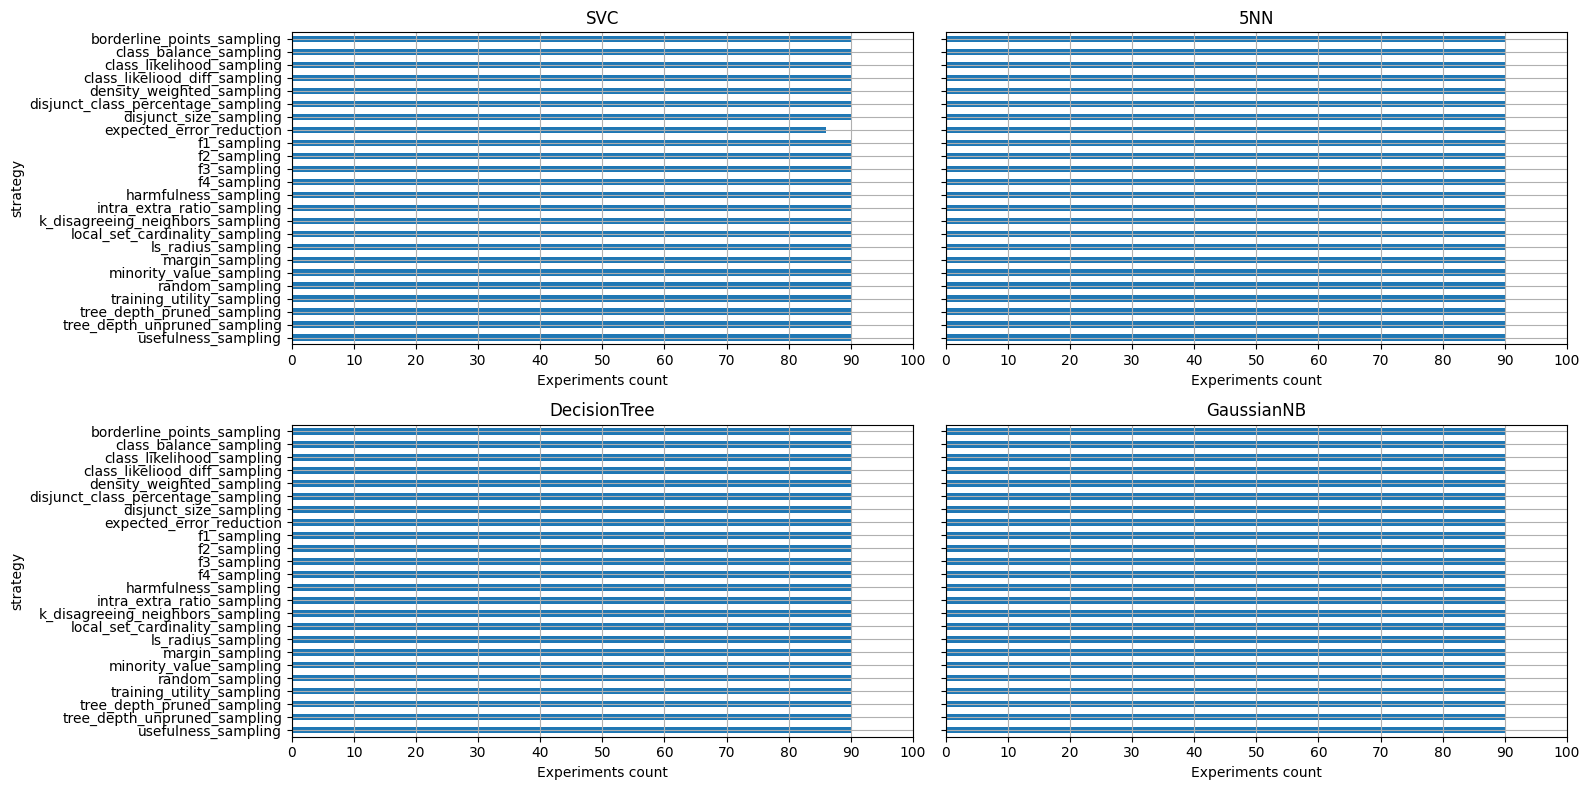

In [22]:
fig, axs = plt.subplots(2,2)

show_counts(df, ax=axs[0, 0], model='SVC')
show_counts(df, ax=axs[0, 1], model='5NN')
show_counts(df, ax=axs[1, 0], model='DecisionTree')
show_counts(df, ax=axs[1, 1], model='GaussianNB')

fig.tight_layout()

## Ranking Curves

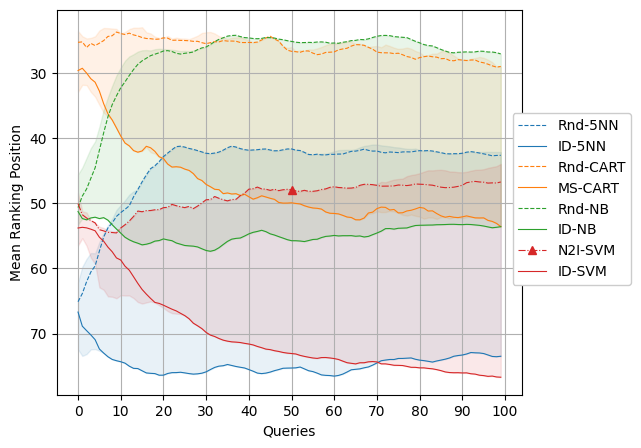

In [96]:
_, ax = plt.subplots(1, 1, figsize=(6,5))
plot_ranks_with_bands(df, ax=ax)
plt.legend(loc='upper right',bbox_to_anchor=(1.25,.75), ncol=1, framealpha=1)
plt.gca().invert_yaxis()
plt.savefig('Images/general_ranking_curves.png', dpi=400, bbox_inches='tight')

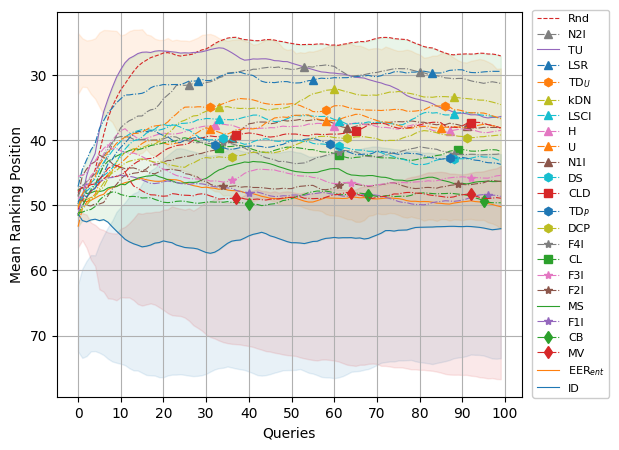

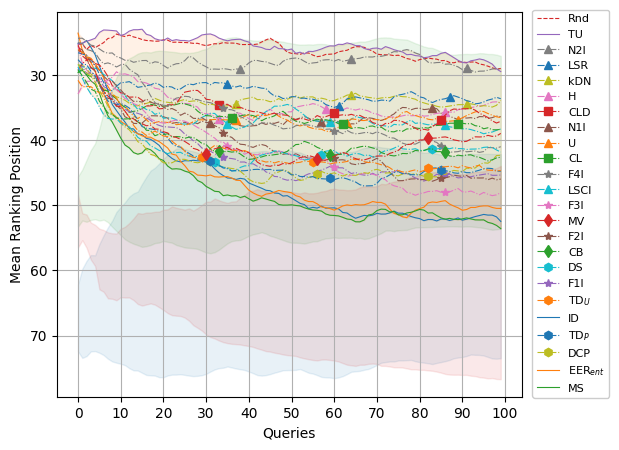

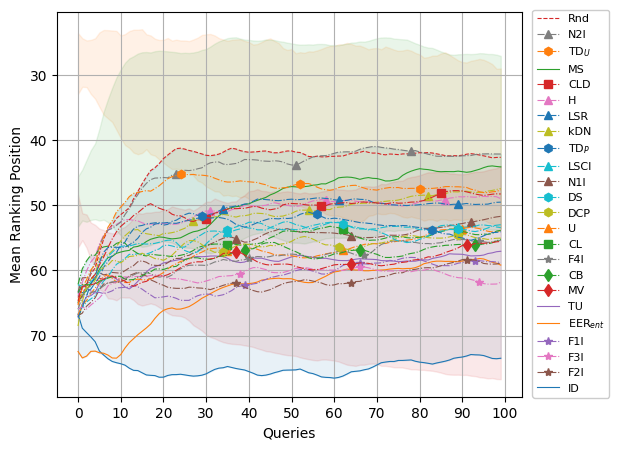

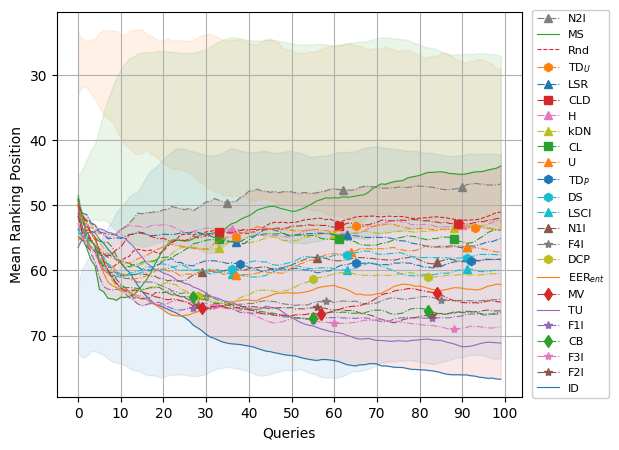

In [95]:

for model in ['GaussianNB', 'DecisionTree', '5NN', 'SVC']:
    
    fig, ax = plt.subplots(1,1, figsize=(6, 5))
    plot_ranks_with_bands(df,ax=ax, model=model, log=False)
    plt.gca().invert_yaxis()
    
    ranks_df  = get_ranks_df(df, model=model)
    ranks_df.strategy = ranks_df.strategy.apply(lambda x: ABREV_DICT[x])
    sorted_labels = ranks_df.strategy
    
    handles, labels = plt.gca().get_legend_handles_labels()
    label_to_handle = {l: h for l, h in zip(labels, handles)}
    
    plt.legend([label_to_handle[label] for label in sorted_labels],
               sorted_labels,
               loc='upper right', bbox_to_anchor=(1.2, 1.02), ncols=1, prop={'size': 8}, framealpha=1)

    plt.savefig(f'Images/{ABREV_MODEL[model]}_ranking_curves.png', dpi=400, bbox_inches='tight')
    plt.show()
    

## Comparação de Categorias

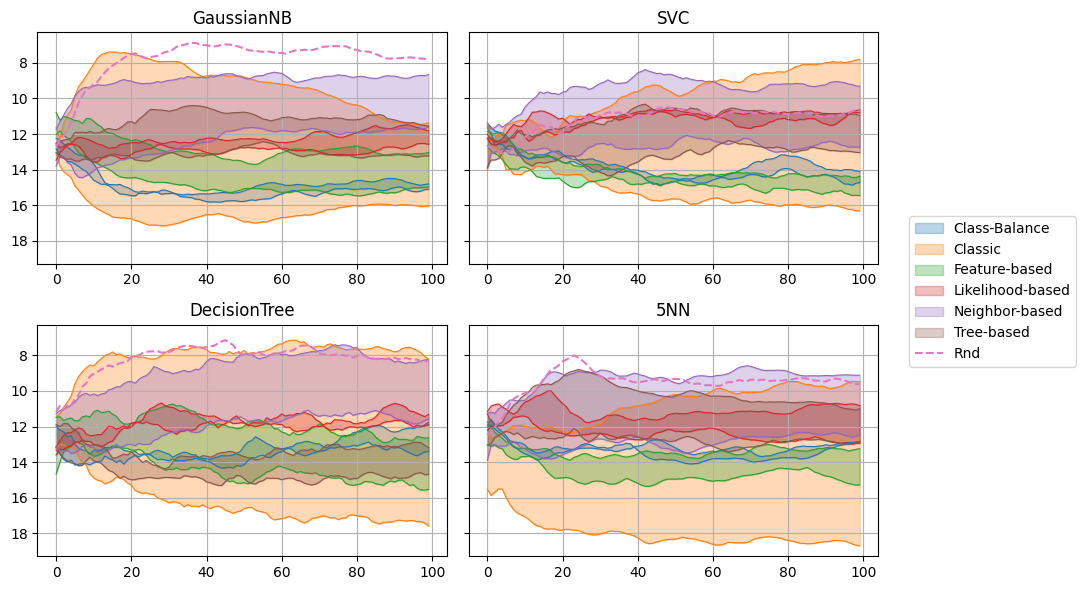

In [117]:
plot_group_bands(df)
plt.gca().invert_yaxis()

## Tabelas

In [91]:
ranks_df  = get_ranks_df(df, model='SVC')
ranks_df.strategy = ranks_df.strategy.apply(lambda x: ABREV_DICT[x])
ranks_df.set_index('strategy').auc_score

strategy
N2I            29.404341
MS             28.508285
Rnd            27.936533
TD$_U$         27.494086
LSR            27.322806
CLD            27.288752
H              27.224661
kDN            26.725875
CL             25.797281
U              24.907728
TD$_P$         24.896012
DS             24.661691
LSCI           24.538236
N1I            24.082702
F4I            23.409488
DCP            23.074074
EER$_{ent}$    22.592451
MV             21.918691
TU             21.703284
F1I            21.596610
CB             21.525153
F3I            21.434596
F2I            21.371887
ID             18.627998
Name: auc_score, dtype: float64

In [34]:
df

,,,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
dataset,model,strategy,,,,,,,,,,,,,,,,,,,,,
optdigits,GaussianNB,random_sampling,0.153476,0.148008,0.182858,0.192310,0.224483,0.216741,0.262228,0.276740,0.272164,0.292280,...,0.676928,0.679498,0.683059,0.691367,0.694133,0.694528,0.695516,0.698677,0.699665,0.699666
ozone-eighthr,SVC,margin_sampling,0.005070,0.000000,0.009096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
artificial-characters,DecisionTree,f1_sampling,0.053092,0.056338,0.056995,0.079489,0.066077,0.065898,0.055595,0.057878,0.076148,0.078141,...,0.087505,0.106933,0.110722,0.105404,0.105559,0.103194,0.123702,0.103445,0.135319,0.138043
wine-quality-white-5class,GaussianNB,class_balance_sampling,0.000221,0.024706,0.001166,0.003714,0.021334,0.024994,0.024535,0.020241,0.033054,0.046609,...,0.143279,0.143142,0.140796,0.138630,0.142234,0.139091,0.140171,0.142181,0.139377,0.138863
phoneme,SVC,k_disagreeing_neighbors_sampling,0.082317,0.119550,0.110855,0.139281,0.148819,0.150405,0.162790,0.165134,0.129983,0.159464,...,0.436860,0.432759,0.438727,0.446497,0.441990,0.440508,0.432909,0.439363,0.431298,0.424358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lymphography,GaussianNB,disjunct_size_sampling,0.295000,0.266570,0.404626,0.297322,0.327023,0.219740,0.204835,0.291263,0.336125,0.363613,...,0.440291,0.450738,0.436132,0.447912,0.483244,0.483244,0.483244,0.472464,0.448878,0.448878
glass,SVC,class_likeliood_diff_sampling,0.000000,0.051127,0.099322,0.025871,0.063686,0.000000,0.000000,0.050138,0.073130,0.043883,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013344,0.000000,0.000000,0.000000
movement-libras,SVC,ls_radius_sampling,0.211907,0.175204,0.180999,0.178576,0.208482,0.169405,0.185223,0.214588,0.220364,0.232137,...,0.532846,0.535822,0.535847,0.538790,0.532837,0.535794,0.538743,0.535728,0.541736,0.547704


In [35]:
ranked_df = df.groupby('dataset').rank(ascending=False)
# ranked_df_smoothed = ranked_df.rolling(window=5, axis='columns', min_periods=1).mean().sort_index(key=sort_curves)

# auc_series = df.groupby(['model', 'strategy']).mean().apply(np.trapz, axis='columns')

In [36]:
table = ranked_df.groupby(['model', 'strategy']).apply(lambda x: x.stack().mean())
table_sorted = table.sort_values().reset_index()
table_sorted['group'] = table_sorted.strategy.apply(get_hm_type)
table_sorted.model = table_sorted.model.apply(lambda x: ABREV_MODEL[x])
table_sorted.strategy = table_sorted.strategy.apply(lambda x: ABREV_DICT[x])
table_sorted = table_sorted[[0, 'model', 'strategy', 'group']]
table_sorted

,0,model,strategy,group
0,25.653222,CART,TU,Classic
1,26.175444,CART,Rnd,Classic
2,27.093500,NB,Rnd,Classic
3,27.880611,CART,N2I,Neighbor-based
4,30.788000,NB,TU,Classic
...,...,...,...,...
91,65.916389,SVM,TU,Classic
92,66.090000,SVM,F1I,Feature-based
93,66.393611,SVM,F3I,Feature-based
94,70.767556,SVM,ID,Classic


In [37]:
header = ['Rank Pos.', 'Learner', 'Method', 'Group']
table_sorted[:48].to_latex(index=False, buf=open('table_rank.tex', 'w'), float_format="%.2f", header=header)
table_sorted[48:].to_latex(index=False, buf=open('table_rank.tex', 'a'), float_format="%.2f", header=header)

In [38]:
header = ['Rank Pos.', 'Method', 'Group']
for m, model_rank in table_sorted.groupby('model'):
    mid = len(model_rank)//2
    model_rank = model_rank.drop(columns='model')
    model_rank[mid:].to_latex( buf=open(f'table_rank_{m}.tex', 'w'), float_format="%.2f", header=header, index=False)
    model_rank[:mid].to_latex( buf=open(f'table_rank_{m}.tex', 'a'), float_format="%.2f", header=header, index=False)
    